[Spec sheet](https://cdn-shop.adafruit.com/product-files/3978/3978_manual_SJ-PM-TFmini-T-01_A03ProductManual_EN.pdf)

On pi it is important to disable the serial console and use `/dev/serial0`

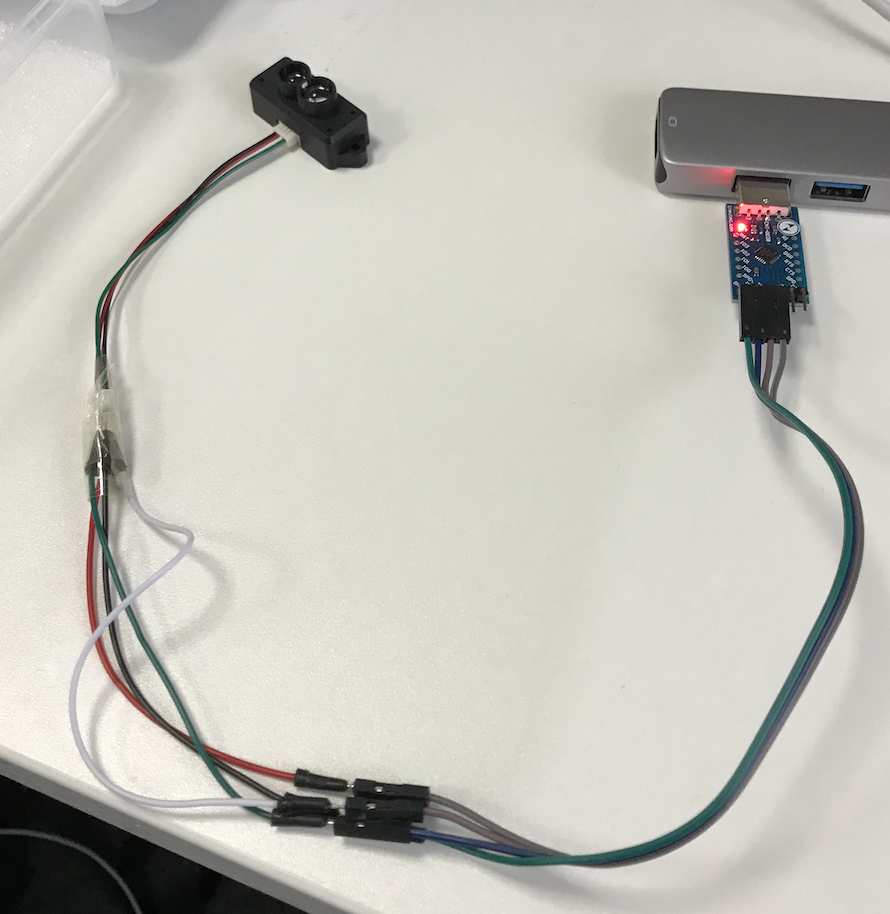

In [1]:
from IPython.display import Image
Image("resources/lidar.png", width=400)

In [2]:
1000000/64

15625.0

Using the lidar above, [bought from Amazon for 30 pounds](https://www.amazon.co.uk/gp/product/B0778B15G7/ref=oh_aui_detailpage_o04_s00?ie=UTF8&psc=1) (cheaper alternatives available)

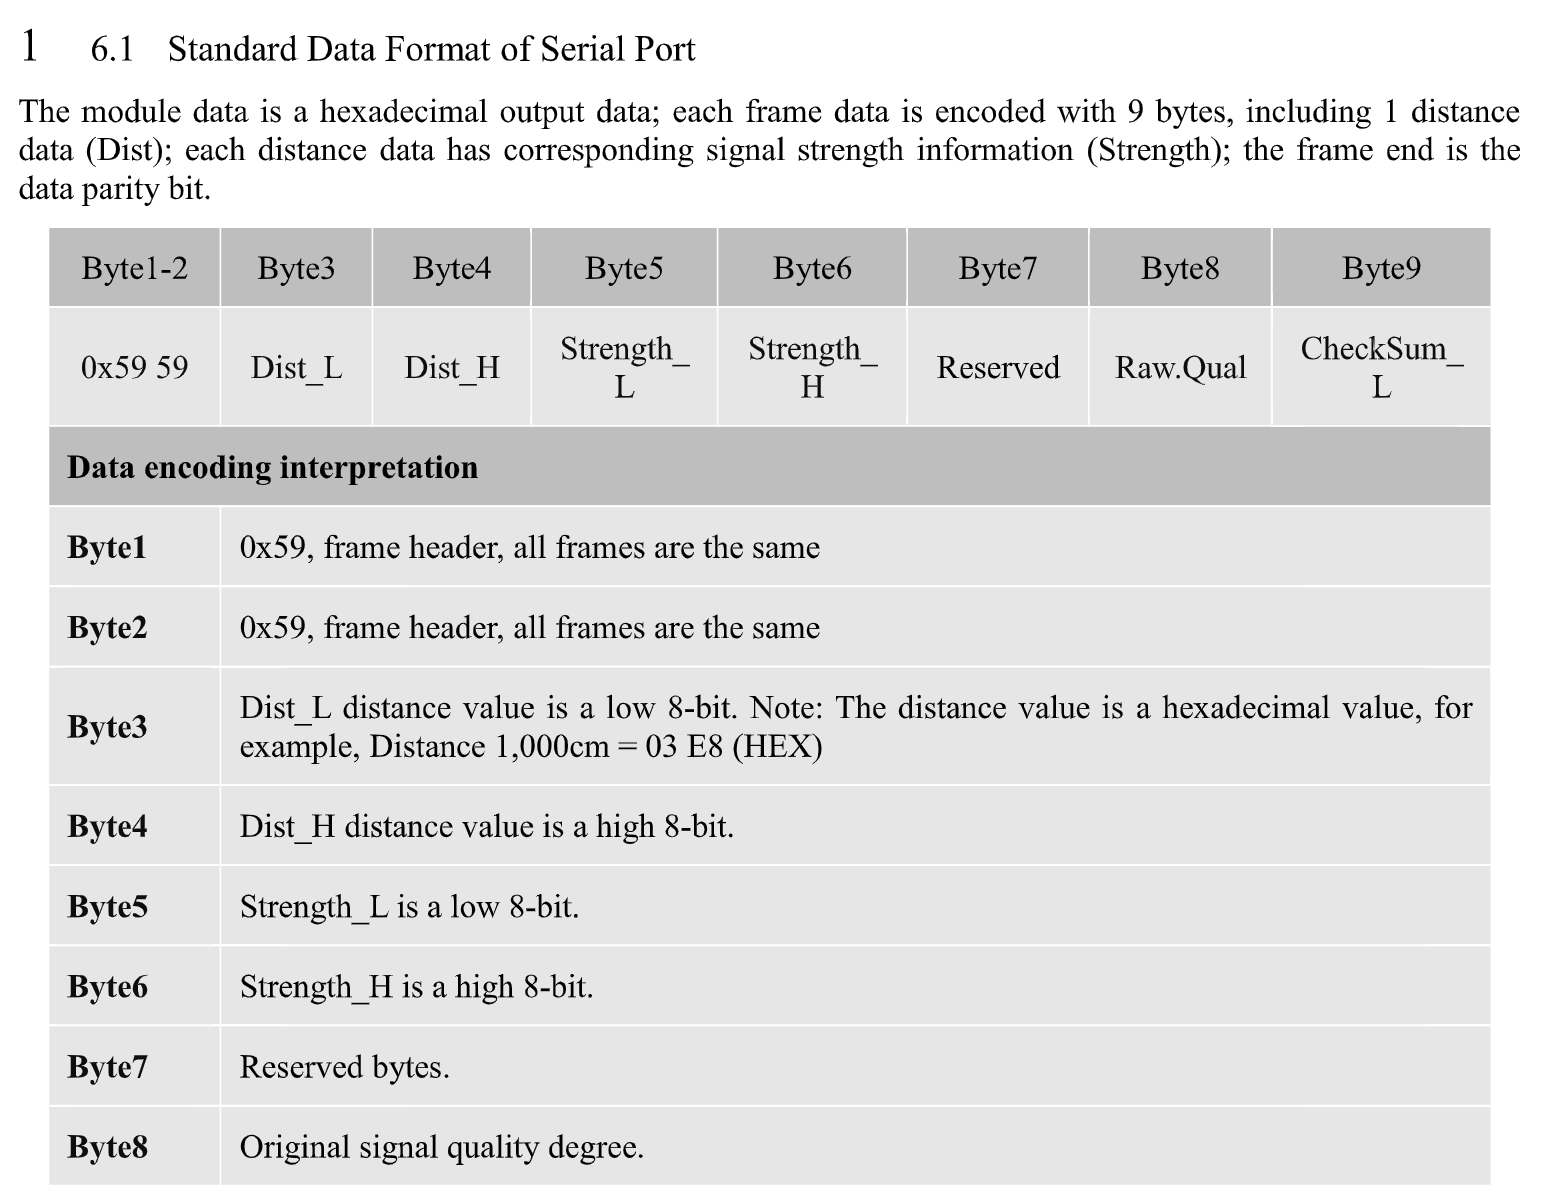

In [3]:
Image("data_protocol.png", width=900)

In [4]:
import serial
import time

In [6]:
!ls /dev/tty*

/dev/tty                         /dev/ttysb
/dev/tty.Bluedio-BluetoothSerial /dev/ttysc
/dev/tty.Bluetooth-Incoming-Port /dev/ttysd
/dev/tty.RobinsiPhone6-Wirelessi /dev/ttyse
/dev/tty.SLAB_USBtoUART          /dev/ttysf
/dev/ttyp0                       /dev/ttyt0
/dev/ttyp1                       /dev/ttyt1
/dev/ttyp2                       /dev/ttyt2
/dev/ttyp3                       /dev/ttyt3
/dev/ttyp4                       /dev/ttyt4
/dev/ttyp5                       /dev/ttyt5
/dev/ttyp6                       /dev/ttyt6
/dev/ttyp7                       /dev/ttyt7
/dev/ttyp8                       /dev/ttyt8
/dev/ttyp9                       /dev/ttyt9
/dev/ttypa                       /dev/ttyta
/dev/ttypb                       /dev/ttytb
/dev/ttypc                       /dev/ttytc
/dev/ttypd                       /dev/ttytd
/dev/ttype                       /dev/ttyte
/dev/ttypf                       /dev/ttytf
/dev/ttyq0                       /dev/ttyu0
/dev/ttyq1                      

In [7]:
SENSOR_PORT = '/dev/tty.SLAB_USBtoUART'

In [8]:
# Class to read sensor

class lidar():
    
    def __init__(self, sensor_port : str):
        self._ser = serial.Serial(sensor_port, 115200, timeout=1)
        
        # Initialise 
        self._ser.write(bytes(b'B'))
        self._ser.write(bytes(b'W'))
        self._ser.write(bytes(2))
        self._ser.write(bytes(0))
        self._ser.write(bytes(0))
        self._ser.write(bytes(0))
        self._ser.write(bytes(1))
        self._ser.write(bytes(6))
        
    def read_lidar(self):
        """
        Take a single reading from the lidar.
        """
        Dist_Total = 0
        while(self._ser.in_waiting >= 9):
            
            
            if((b'Y' == self._ser.read()) and ( b'Y' == self._ser.read())):
            
                Dist_L = self._ser.read()
                Dist_H = self._ser.read()
                Dist_Total = (ord(Dist_H) * 256) + (ord(Dist_L))
                for i in range (0,5):
                    self._ser.read()
        return Dist_Total

In [9]:
lidar_1 = lidar(SENSOR_PORT)

Now we just place in a loop to read the sensor -> will require own thread as we are continually polling the sensor

In [11]:
curr_reading = None
THRESHOLD = 100 # the distance threshold that determines if the sensor is ON or OFF
state = False
READINGS = 100
SLEEP_TIME = 0.2

for i in range(READINGS):
    curr_reading = lidar_1.read_lidar()
    if curr_reading < THRESHOLD:
        state = False
    else:
        state = True
    print((curr_reading, state))
    time.sleep(SLEEP_TIME)

(200, True)
(200, True)
(200, True)
(200, True)
(200, True)
(33, False)
(30, False)
(30, False)
(30, False)
(30, False)
(30, False)
(198, True)
(200, True)
(200, True)
(203, True)
(205, True)
(205, True)
(205, True)
(205, True)
(205, True)
(33, False)
(30, False)
(30, False)
(30, False)
(30, False)
(30, False)
(30, False)
(30, False)
(30, False)
(198, True)
(200, True)
(200, True)
(200, True)
(200, True)
(200, True)
(200, True)
(200, True)
(200, True)
(200, True)
(200, True)
(200, True)
(200, True)
(200, True)
(200, True)
(200, True)


KeyboardInterrupt: 

## AWS deployment
Publish the data over MQTT, we should use a Rule on AWS to determine the sensor threshold for state detection. For topic use the thing name. 

In [8]:
from aws_mqtt import aws_mqtt_broker

In [9]:
broker = aws_mqtt_broker(client_id="robins_mac")

Connected to AWS MQTT broker


In [10]:
THING_NAME = "robins-lidar"

In [11]:
broker.publish(topic=THING_NAME, message="0")

Published message : 0 | topic : robins-lidar


In [12]:
for i in range(5):
    curr_reading = lidar_1.read_lidar()
    broker.publish(topic=THING_NAME, message=str(curr_reading))
    time.sleep(1)

Published message : 201 | topic : robins-lidar
Published message : 201 | topic : robins-lidar
Published message : 201 | topic : robins-lidar
Published message : 201 | topic : robins-lidar
Published message : 201 | topic : robins-lidar


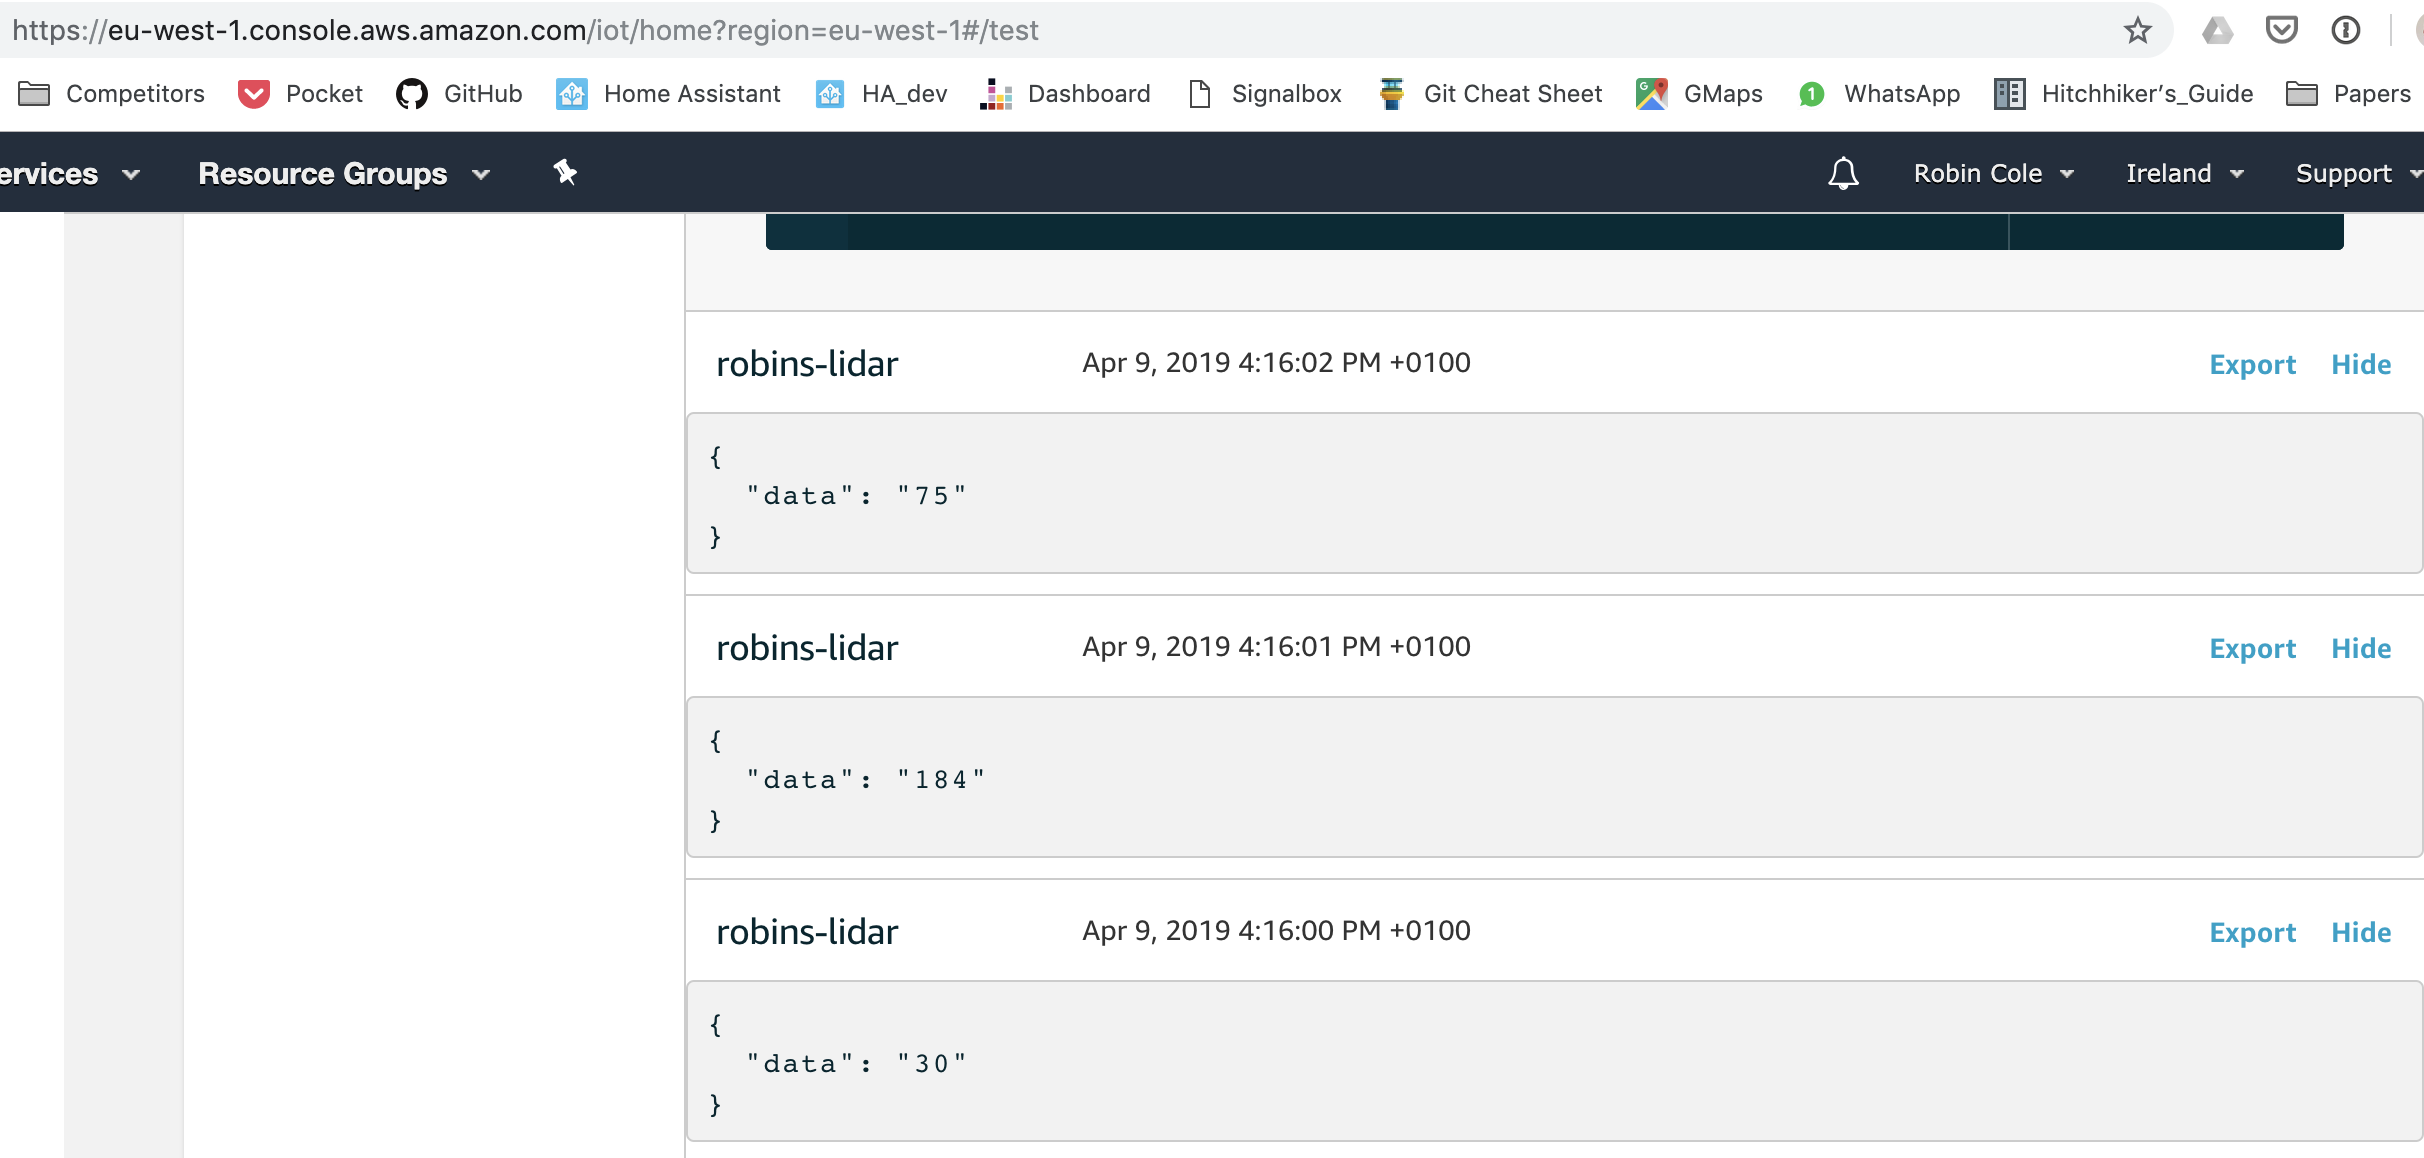

In [13]:
Image("resources/data_on_amazon.png", width=700)